In [1]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, SimpleRNN, Reshape, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb


import seaborn as sns


# Loading datasets

In [2]:
df1 = pd.read_csv("./dataset/backloggd_games.csv")
df2 = pd.read_csv("./dataset/video_games_sales.csv") 
df3 = pd.read_csv("./dataset/video_game_reviews.csv")


merged_df = pd.merge(df1,df2, left_on="Title", right_on="name", how="inner")
df = pd.merge(merged_df, df3, left_on="Title", right_on="Game Title", how="inner")

df.shape

(81729, 43)

# Exploratory Data Analysis

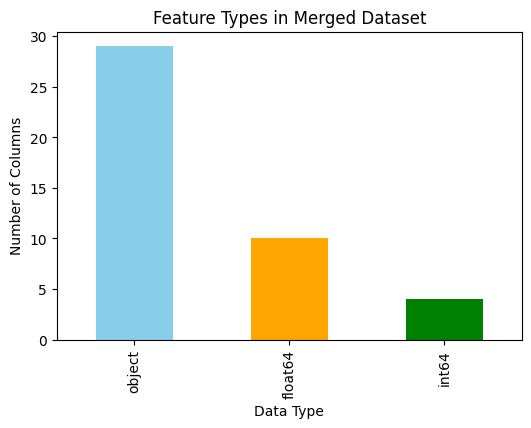

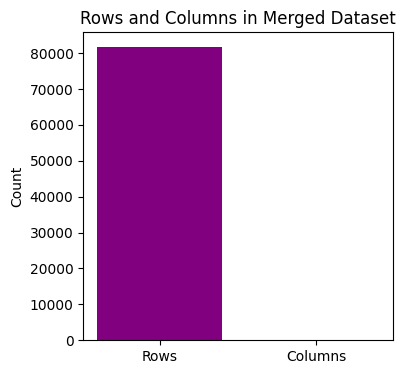

In [3]:
# Count feature types
feature_types = df.dtypes.value_counts()

# Plot feature types
plt.figure(figsize=(6,4))
feature_types.plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("Feature Types in Merged Dataset")
plt.xlabel("Data Type")
plt.ylabel("Number of Columns")
plt.show()

# Visualize rows and columns
plt.figure(figsize=(4,4))
plt.bar(['Rows', 'Columns'], [df.shape[0], df.shape[1]], color=['purple', 'teal'])
plt.title("Rows and Columns in Merged Dataset")
plt.ylabel("Count")
plt.show()

# Column Distribution

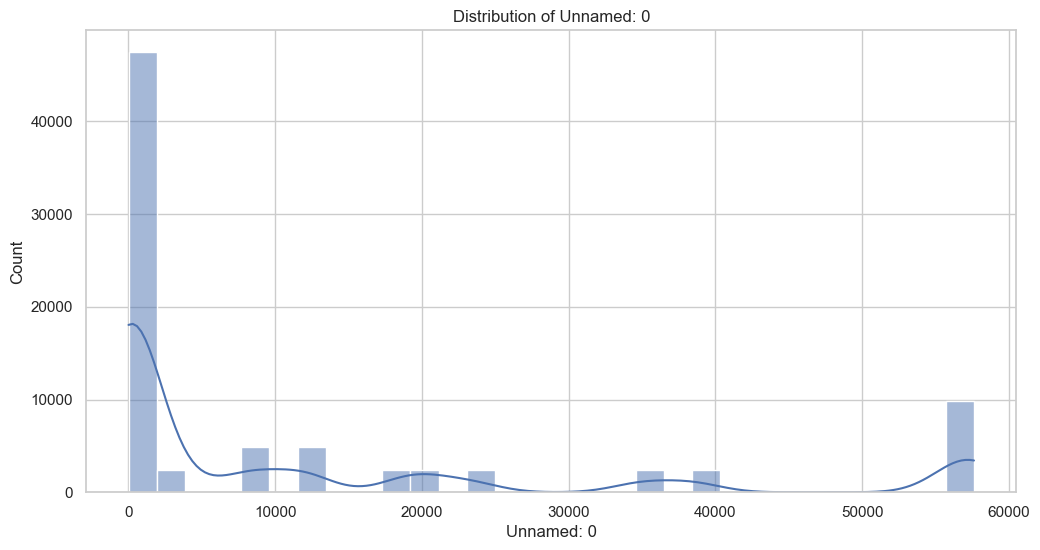

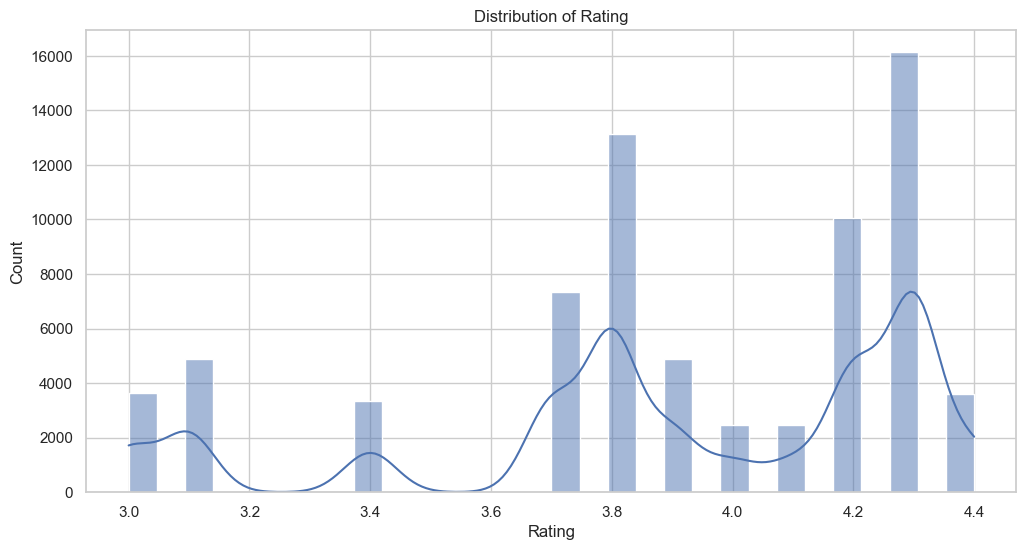

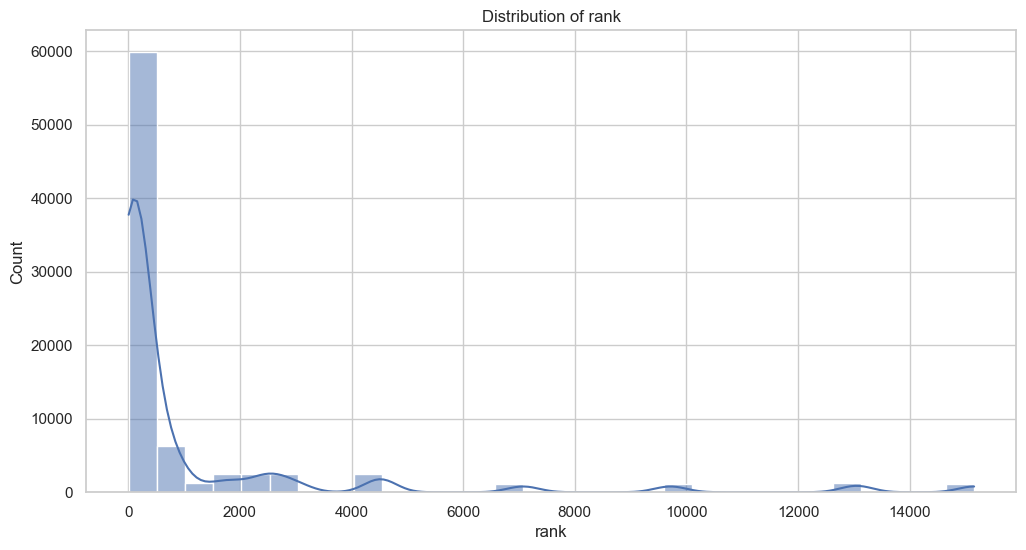

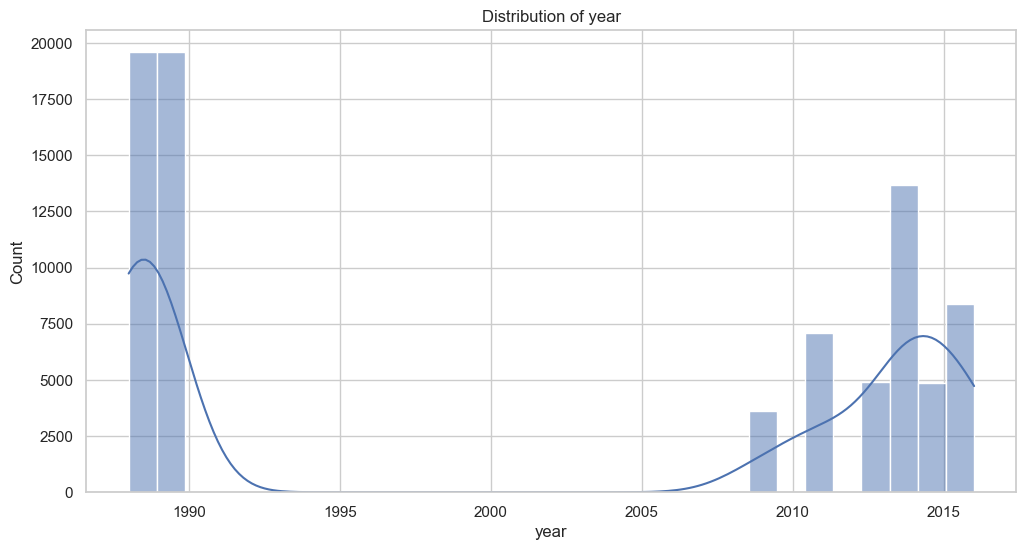

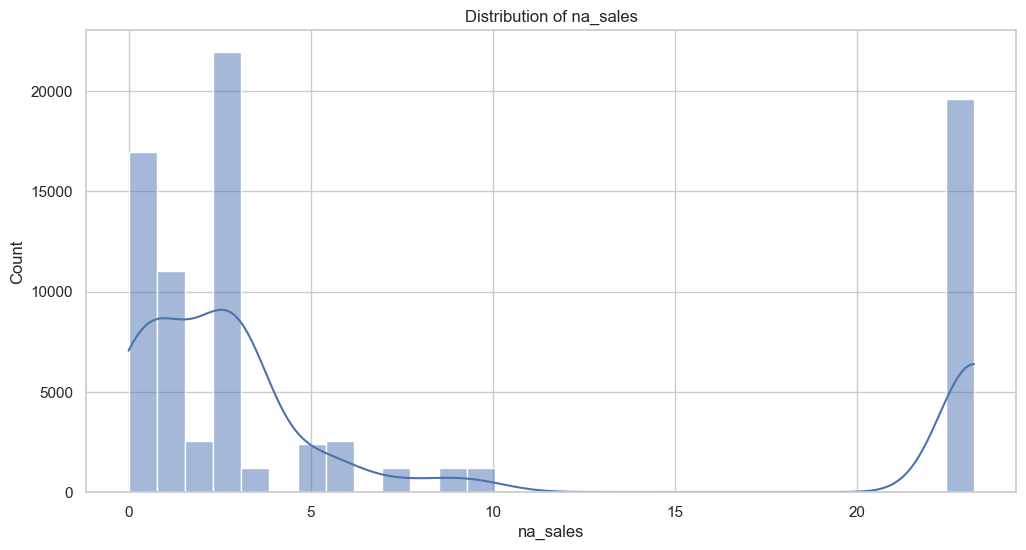

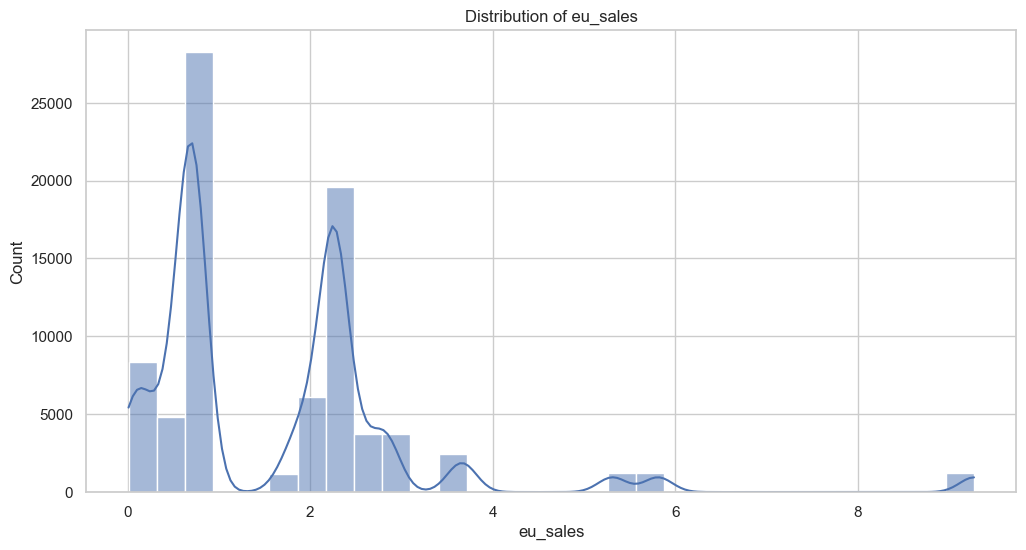

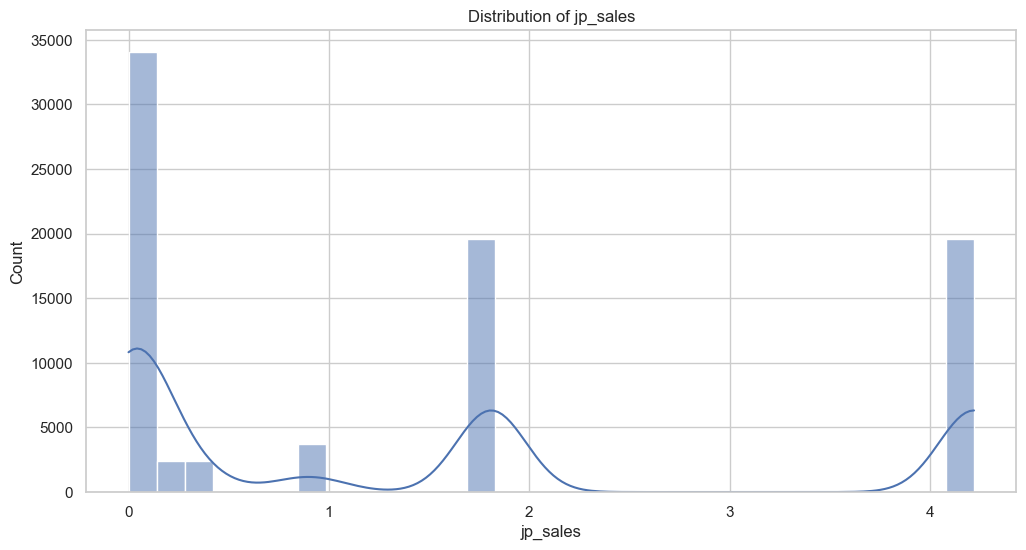

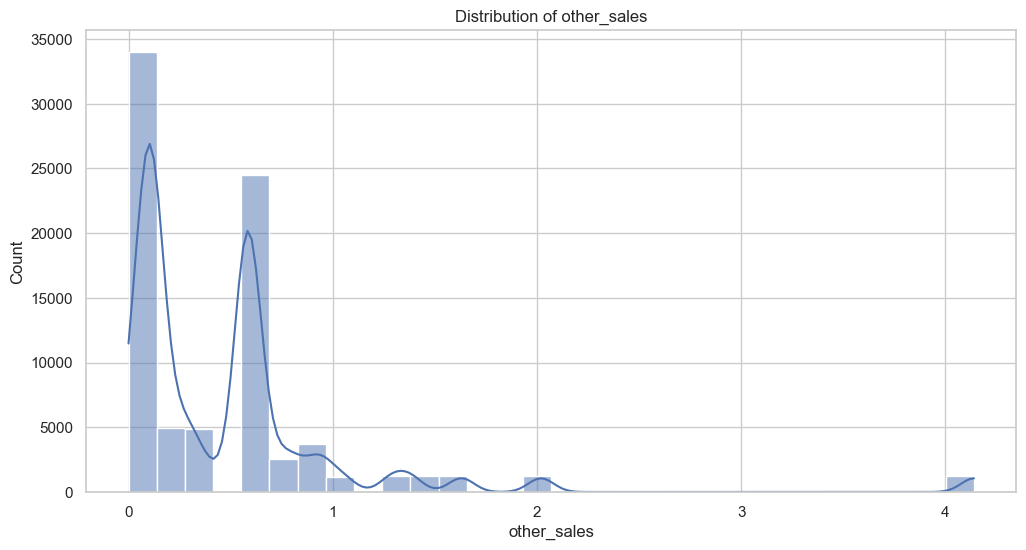

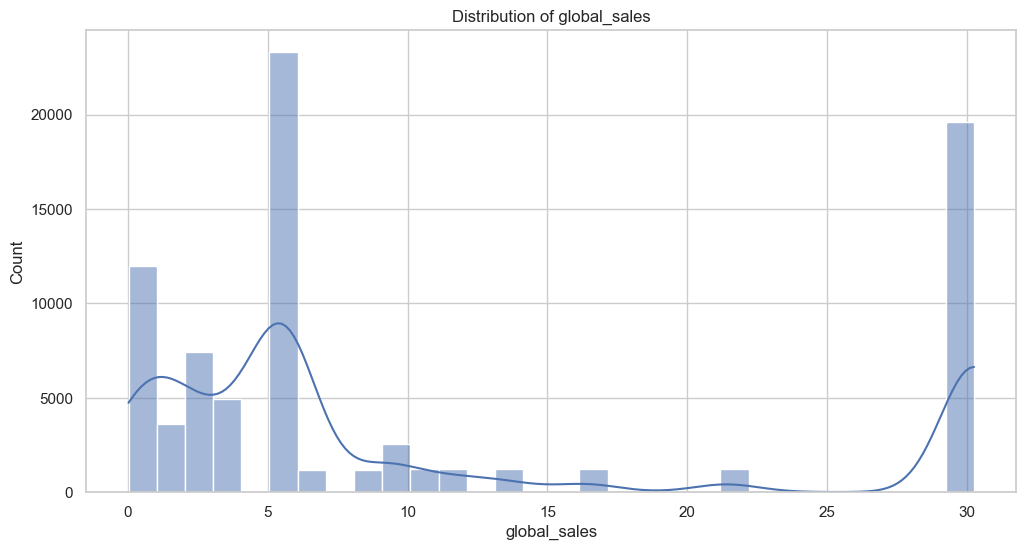

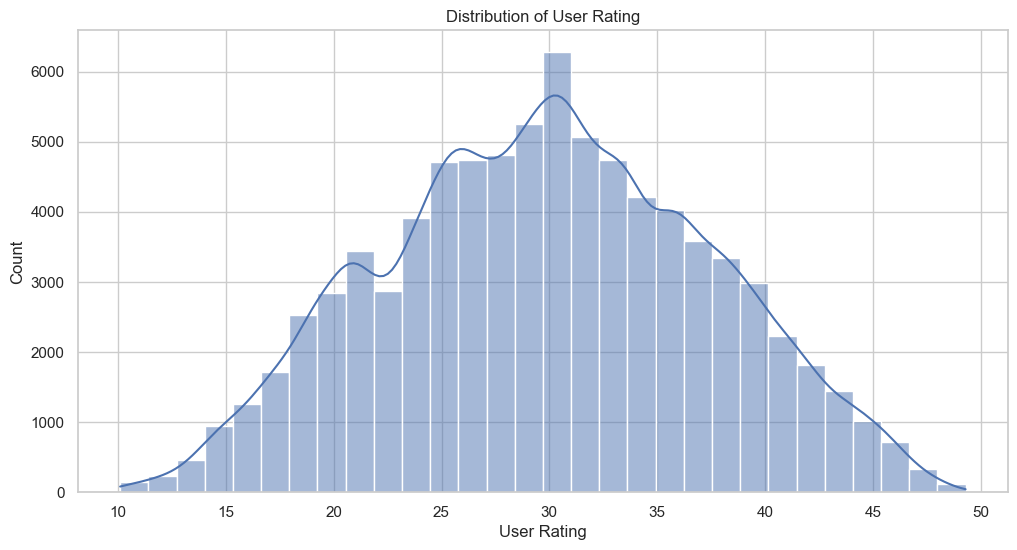

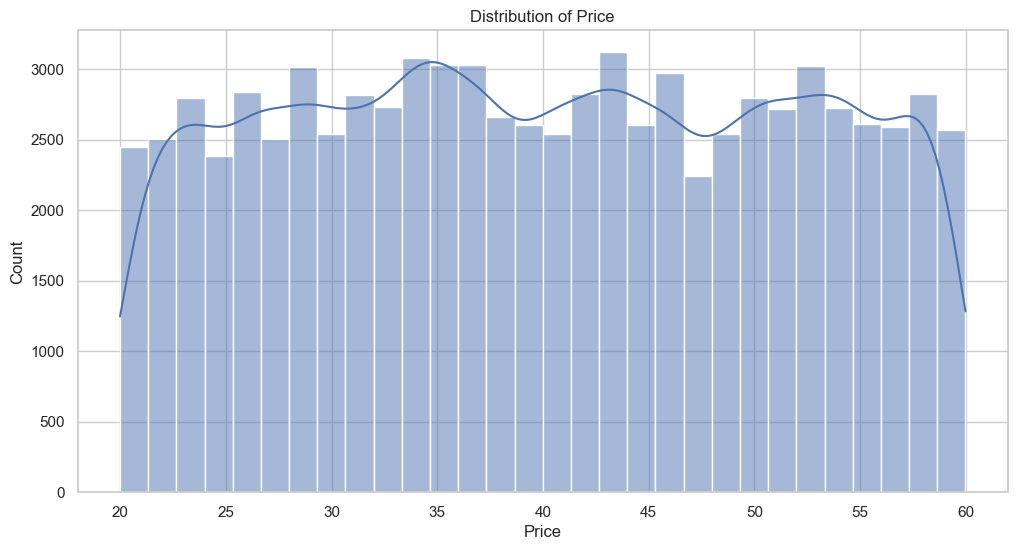

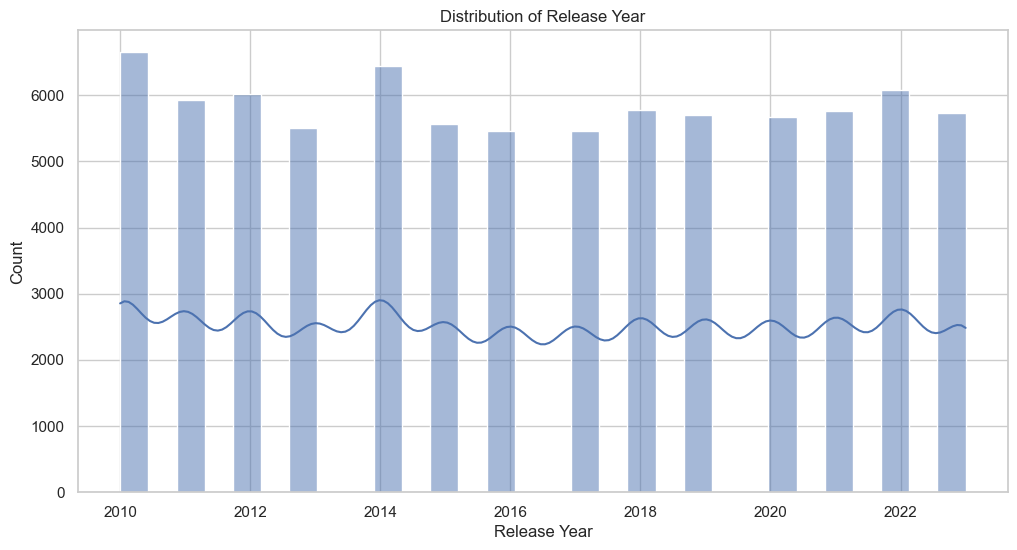

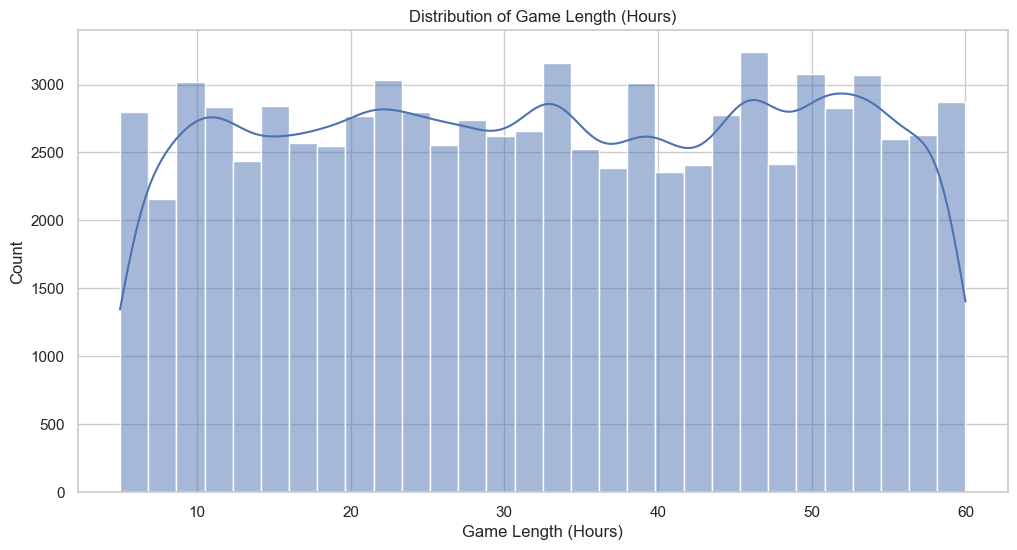

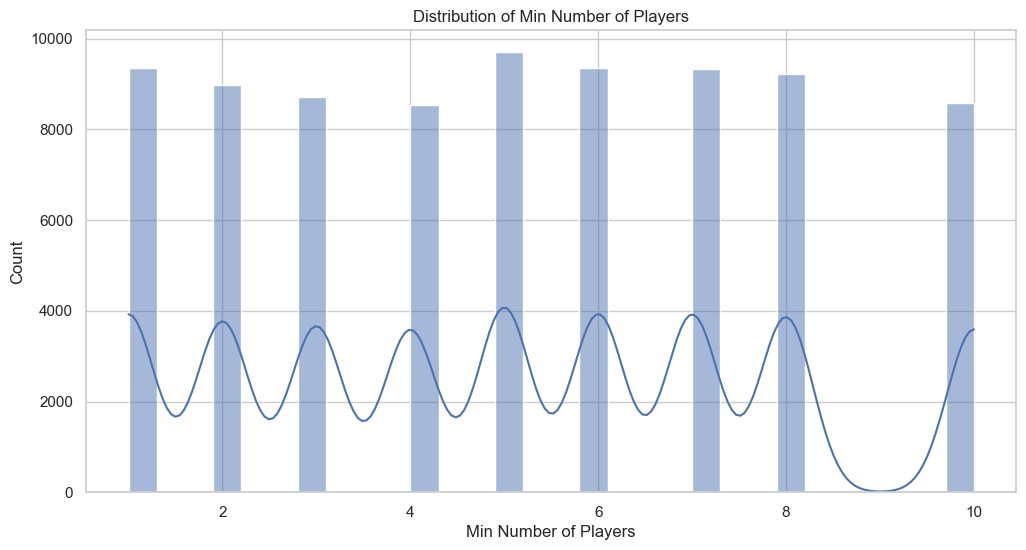

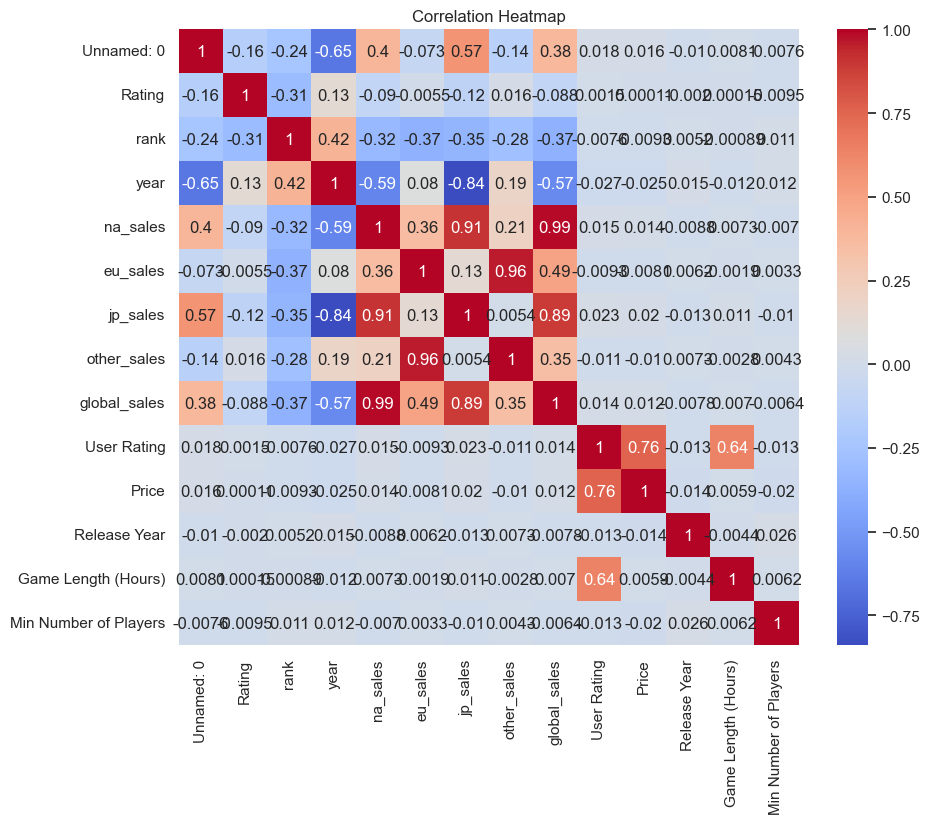

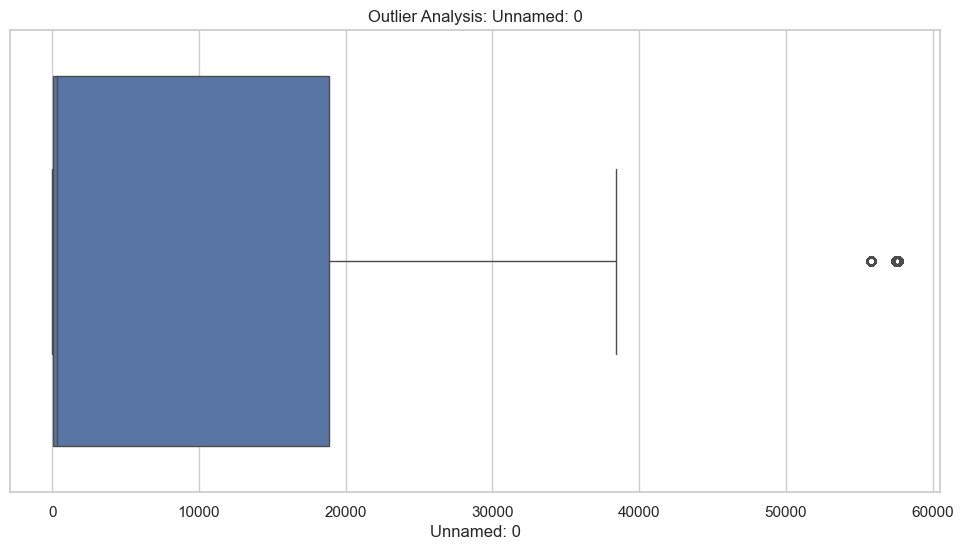

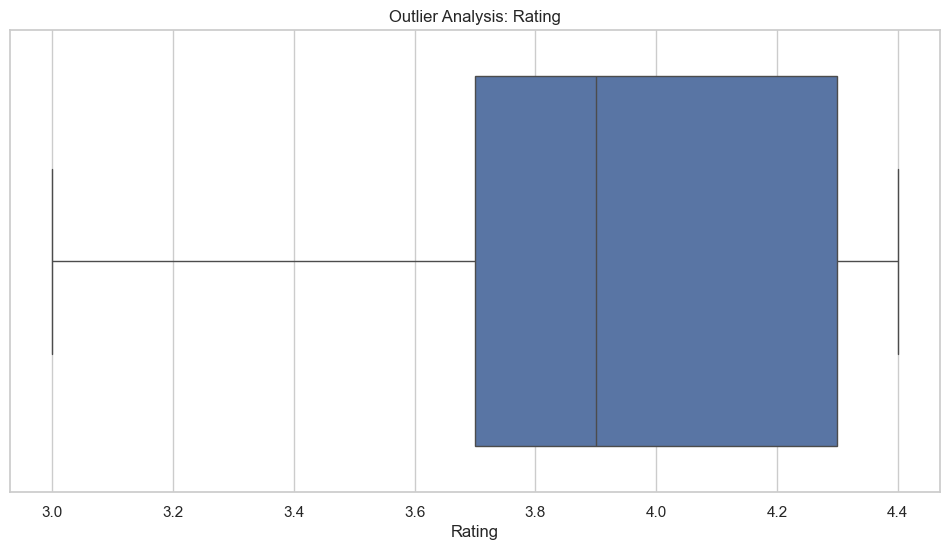

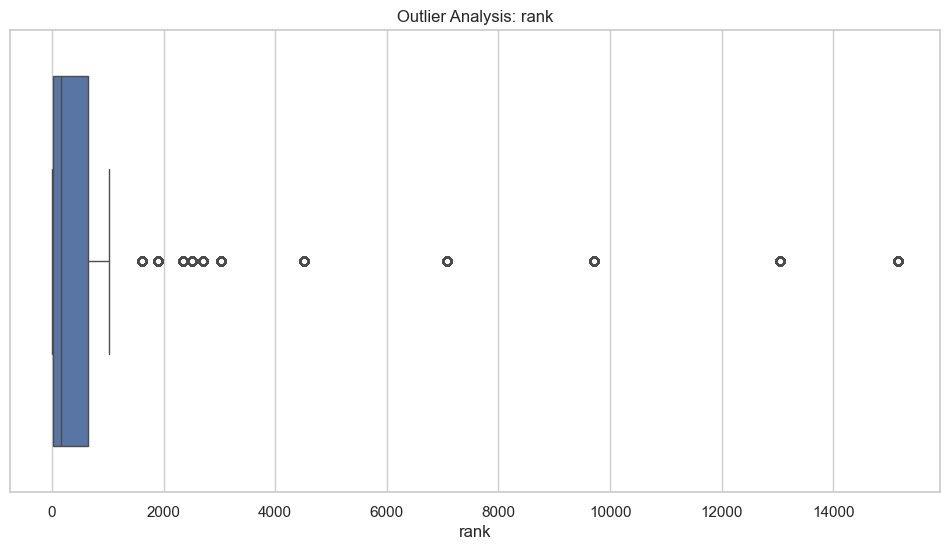

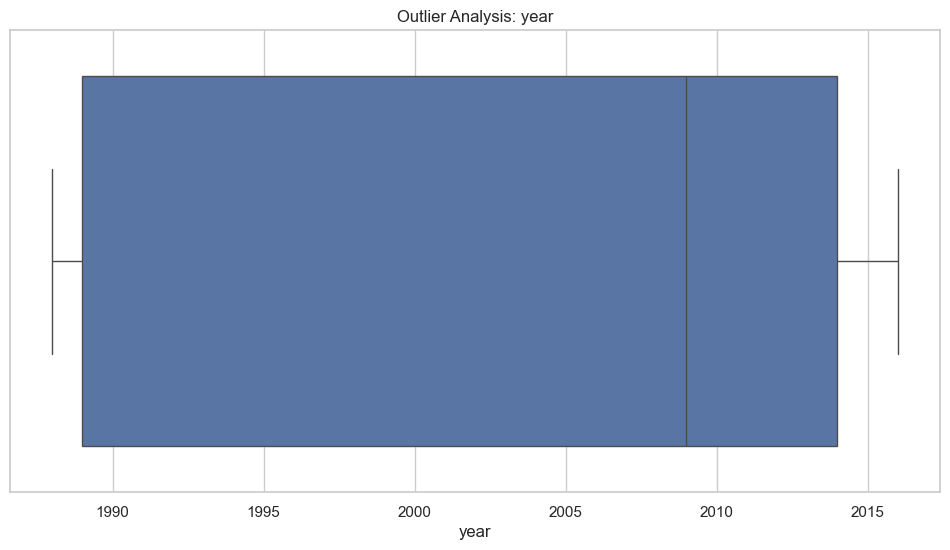

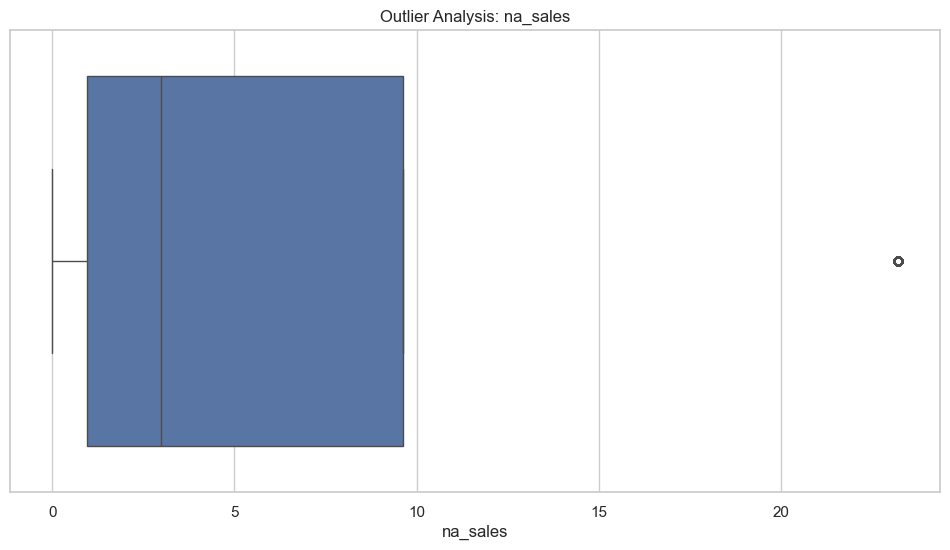

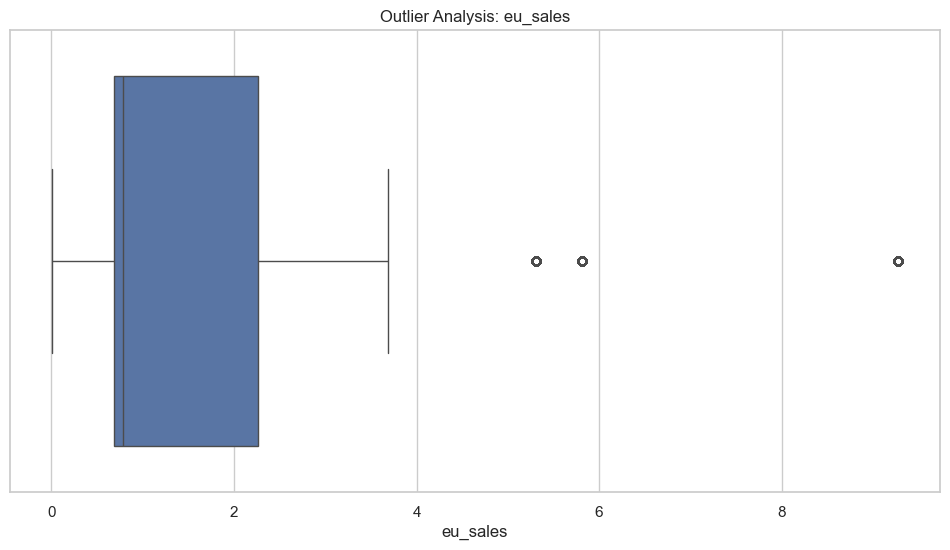

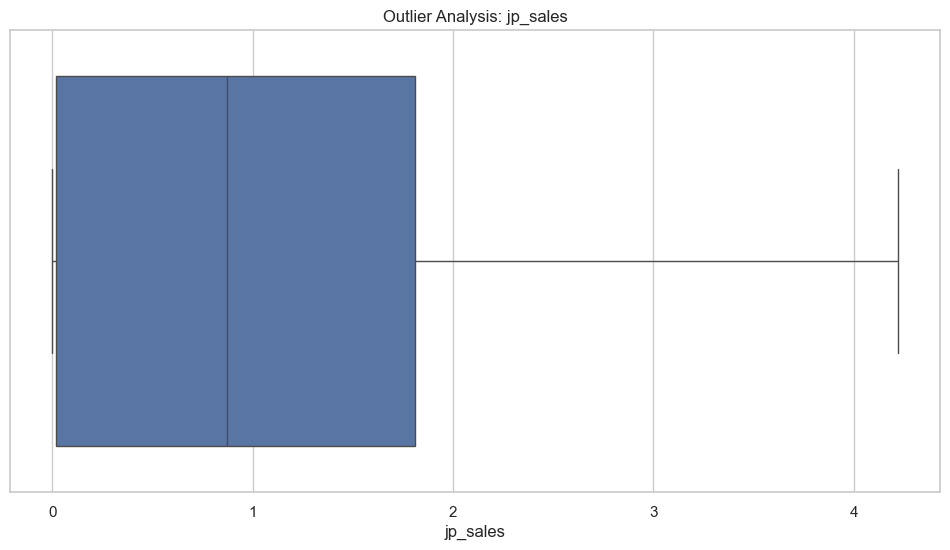

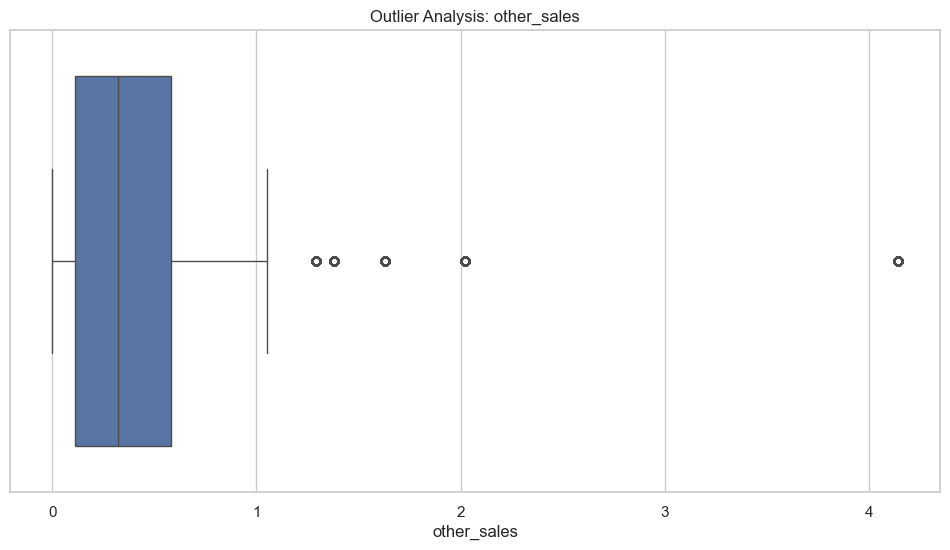

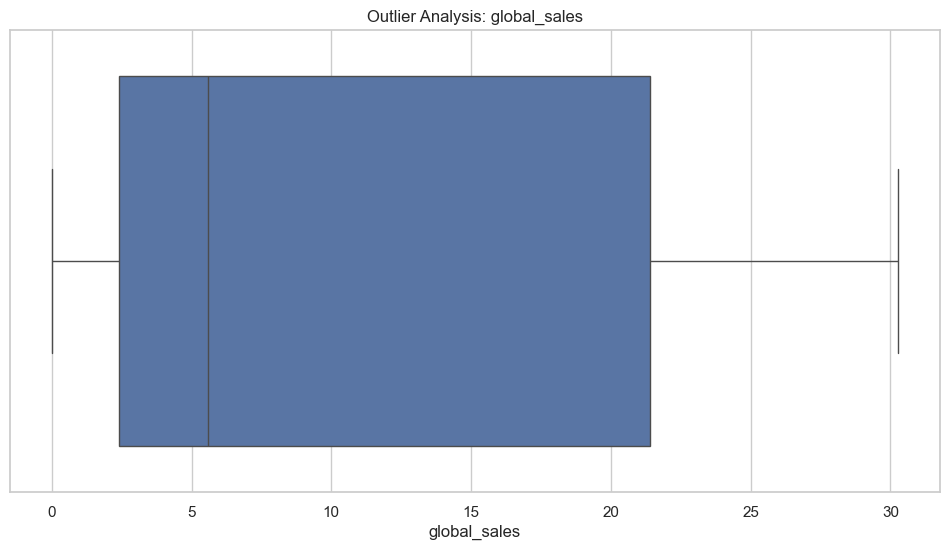

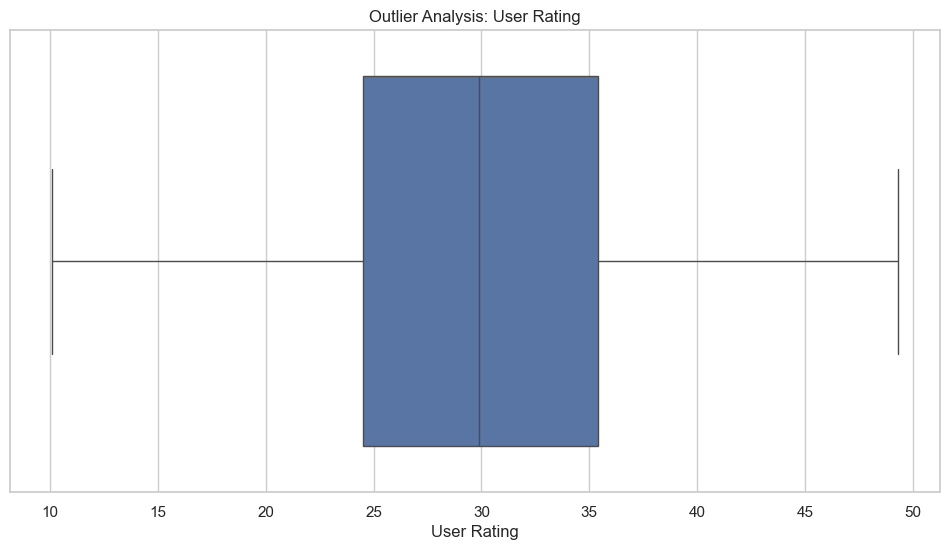

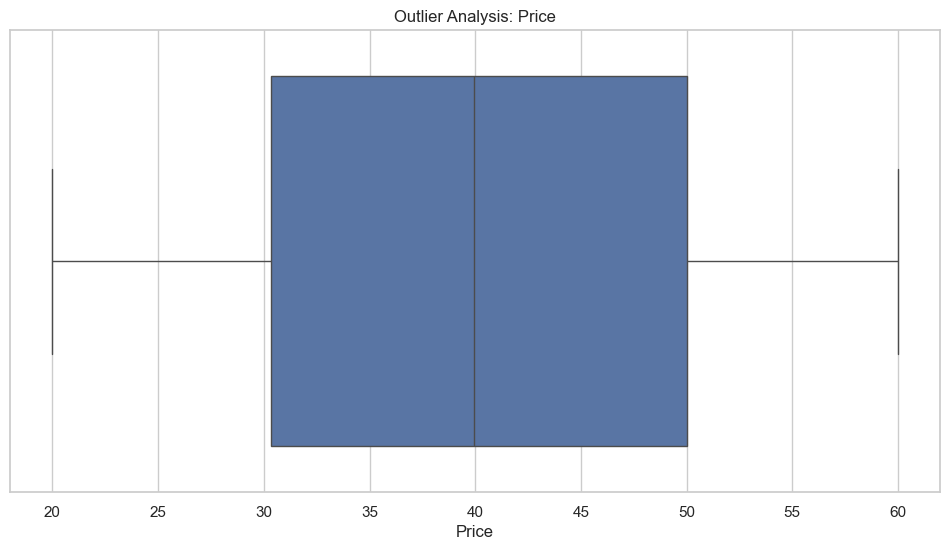

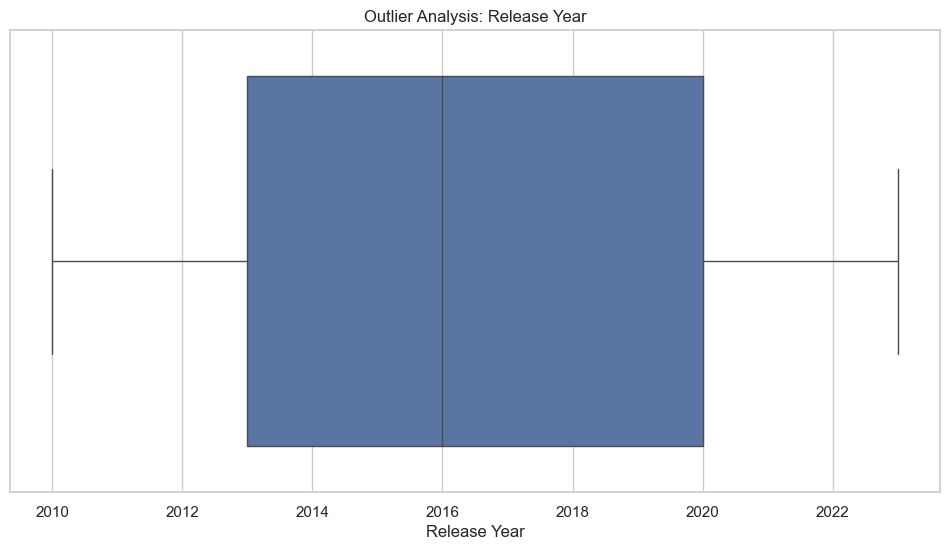

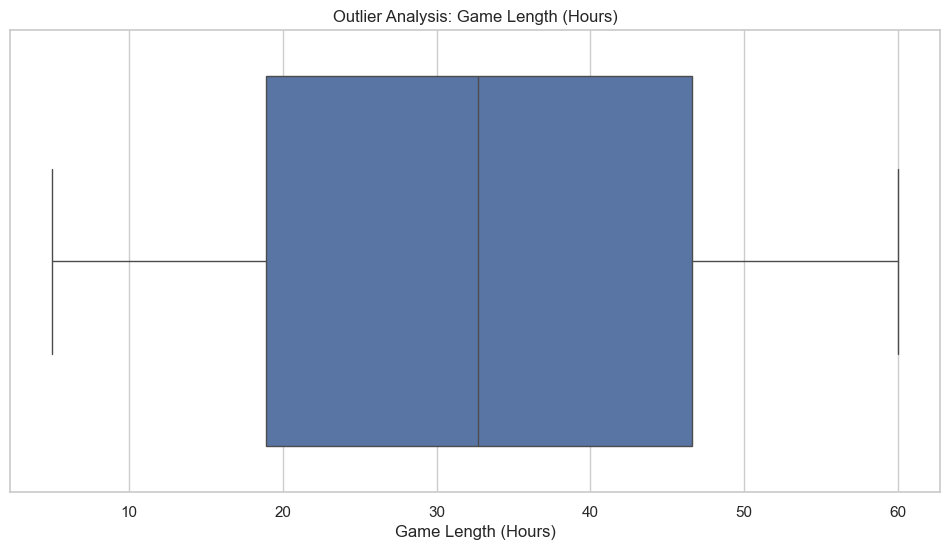

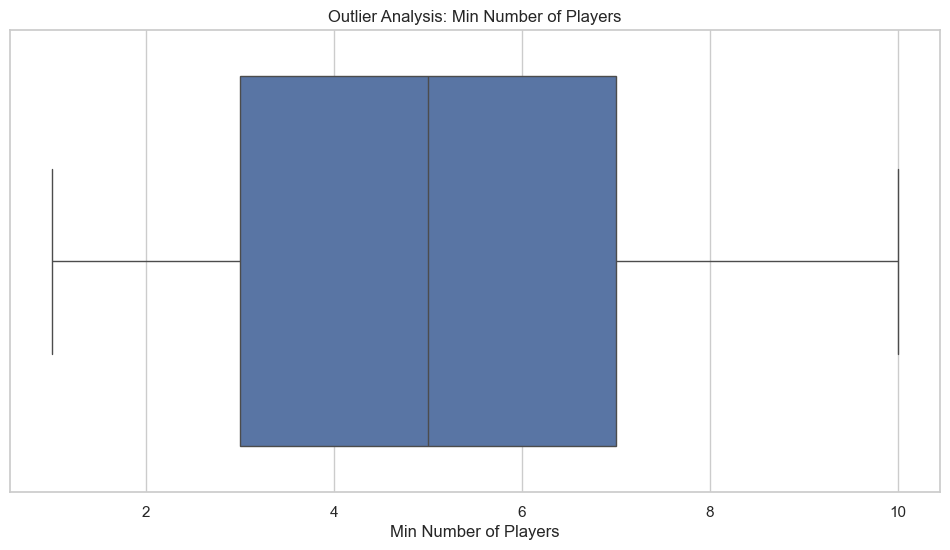

In [4]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Outlier Analysis: {col}')
    plt.show()

# Dropping unneeded columns

In [5]:


df = df.drop(columns=[
    "Unnamed: 0",
    "platform",
    "name",
    "Summary",
    "rank",
    "na_sales",
    "Game Title",
    "eu_sales",
    "Min Number of Players",
    "jp_sales",
    "other_sales",
    "Title",
    "Release_Date",
    "Developers",
    "Release Year",
    "Publisher"
])


df.sample(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81729 entries, 0 to 81728
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Platforms                81729 non-null  object 
 1   Genres                   81729 non-null  object 
 2   Rating                   71937 non-null  float64
 3   Plays                    81729 non-null  object 
 4   Playing                  81729 non-null  object 
 5   Backlogs                 81729 non-null  object 
 6   Wishlist                 81729 non-null  object 
 7   Lists                    81729 non-null  object 
 8   Reviews                  81729 non-null  object 
 9   year                     81729 non-null  float64
 10  genre                    81729 non-null  object 
 11  publisher                81729 non-null  object 
 12  global_sales             81729 non-null  float64
 13  User Rating              81729 non-null  float64
 14  Age Group Targeted    

In [6]:
df['global_sales'].mean()
df.isnull().sum()

Platforms                     0
Genres                        0
Rating                     9792
Plays                         0
Playing                       0
Backlogs                      0
Wishlist                      0
Lists                         0
Reviews                       0
year                          0
genre                         0
publisher                     0
global_sales                  0
User Rating                   0
Age Group Targeted            0
Price                         0
Platform                      0
Requires Special Device       0
Developer                     0
Genre                         0
Multiplayer                   0
Game Length (Hours)           0
Graphics Quality              0
Soundtrack Quality            0
Story Quality                 0
User Review Text              0
Game Mode                     0
dtype: int64

# Removing null values

In [7]:
df.isnull().sum()

df["Rating"] = df["Rating"].fillna(df["Rating"].median())

df["year"] = df["year"].fillna(df["year"].median())

df["publisher"] = df["publisher"].fillna("Unknown")

df.isnull().sum()

Platforms                  0
Genres                     0
Rating                     0
Plays                      0
Playing                    0
Backlogs                   0
Wishlist                   0
Lists                      0
Reviews                    0
year                       0
genre                      0
publisher                  0
global_sales               0
User Rating                0
Age Group Targeted         0
Price                      0
Platform                   0
Requires Special Device    0
Developer                  0
Genre                      0
Multiplayer                0
Game Length (Hours)        0
Graphics Quality           0
Soundtrack Quality         0
Story Quality              0
User Review Text           0
Game Mode                  0
dtype: int64

# Coercing numeric columns

In [8]:
num_cols = ["Plays", "Playing", "Backlogs", "Wishlist", "Lists",]

for col in num_cols:
    df[col] = df[col].str.replace(",", "")  
    df[col] = pd.to_numeric(df[col], errors='coerce') 
    
df[num_cols] = df[num_cols].fillna(0)


# Label Encoding high cardinality categorical columns

In [9]:

high_card_cols = ["Developer", "publisher", "Genres", "Platforms", "Age Group Targeted"]
le = LabelEncoder()

for col in high_card_cols:
    df[col] = le.fit_transform(df[col])


# Binary Encoding categorical columns

In [10]:
binary_cols = ['Requires Special Device','Multiplayer', 'Graphics Quality', 'Soundtrack Quality','Story Quality','Game Mode']

df = pd.get_dummies(df, columns=binary_cols, drop_first=True)

In [11]:
df.info()
df.sample(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81729 entries, 0 to 81728
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platforms                     81729 non-null  int32  
 1   Genres                        81729 non-null  int32  
 2   Rating                        81729 non-null  float64
 3   Plays                         81729 non-null  float64
 4   Playing                       81729 non-null  float64
 5   Backlogs                      81729 non-null  float64
 6   Wishlist                      81729 non-null  float64
 7   Lists                         81729 non-null  float64
 8   Reviews                       81729 non-null  object 
 9   year                          81729 non-null  float64
 10  genre                         81729 non-null  object 
 11  publisher                     81729 non-null  int32  
 12  global_sales                  81729 non-null  float64
 13  U

,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews,year,...,Graphics Quality_Low,Graphics Quality_Medium,Graphics Quality_Ultra,Soundtrack Quality_Excellent,Soundtrack Quality_Good,Soundtrack Quality_Poor,Story Quality_Excellent,Story Quality_Good,Story Quality_Poor,Game Mode_Online
28898,8,3,4.2,0.0,595.0,487.0,109.0,707.0,570,2013.0,...,False,True,False,False,False,False,False,True,False,False
73248,6,8,3.9,2.0,0.0,0.0,0.0,2.0,0,1988.0,...,True,False,False,False,True,False,False,False,True,False
14497,17,2,3.8,0.0,958.0,0.0,757.0,0.0,1.7K,2014.0,...,False,True,False,False,True,False,False,False,False,True
41552,11,9,3.0,0.0,516.0,811.0,119.0,520.0,454,2014.0,...,False,False,True,False,False,False,False,False,False,False
14918,17,2,3.8,0.0,958.0,0.0,757.0,0.0,1.7K,2014.0,...,True,False,False,False,False,False,False,True,False,True
11293,17,2,3.8,0.0,958.0,0.0,757.0,0.0,1.7K,2013.0,...,False,False,True,False,False,False,True,False,False,False
76317,4,8,3.7,77.0,0.0,11.0,7.0,18.0,5,1988.0,...,False,True,False,False,False,True,False,True,False,False
293,10,3,4.3,0.0,0.0,0.0,265.0,0.0,2.7K,2013.0,...,True,False,False,False,False,False,True,False,False,False
25254,9,6,3.4,0.0,664.0,785.0,124.0,0.0,721,2016.0,...,False,True,False,False,False,True,True,False,False,True
28935,8,3,4.2,0.0,595.0,487.0,109.0,707.0,570,2013.0,...,False,False,True,False,False,False,False,True,False,False


# Loading dataset for setiment analysis model and mapping target column to 0's and 1's

In [12]:
sentiment_df = pd.read_csv("./dataset/output.csv")

sentiment_df['is_positive'] = sentiment_df['is_positive'].map({'Positive':1, 'Negative':0})

sentiment_df.sample(10)

,id,app_id,content,author_id,is_positive
55358,177878604,730,"""Do something about the cheaters. The number o...",76561199509640447,0
153312,175097827,620,"Simply put, best Puzzle game and narrative ever.",76561199034310547,1
44565,167933598,440,my friend leaf0n likes it so im inclined to ha...,76561199006877367,0
11711,44883280,240,Coppied csgo,76561198130160847,0
59232,175501591,730,ni,76561198997508685,0
192673,144718270,570,Do better things in life,76561198341542838,0
138641,11152706,340,never played and never will.,76561198067266660,1
80479,122693283,130,"I liked the part where he said ""It's shiftin' ...",76561198390662310,1
17823,60456988,60,"A fun concept, but there are literally no play...",76561198276538434,0
189069,165934528,730,NaN,76561199529994850,0


In [13]:
reviews = sentiment_df['content'].astype(str)
y = sentiment_df['is_positive'].values

# Preparing text data for input to the model by converting raw text to padded integer sequences

In [14]:
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews)

X_seq = tokenizer.texts_to_sequences(reviews)
X_pad = pad_sequences(X_seq, maxlen=max_len)


# Splitting into training and testing sets

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_pad, y, test_size=0.2, random_state=42
)


# Model Training

In [16]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\abdel\Desktop\Senior Year\AI\venv2\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=10,          
    batch_size=128,
    validation_data=(X_val, y_val)
)


Epoch 1/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.8149 - loss: 0.3962 - val_accuracy: 0.8446 - val_loss: 0.3429
Epoch 2/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8546 - loss: 0.3279 - val_accuracy: 0.8472 - val_loss: 0.3404
Epoch 3/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.8638 - loss: 0.3076 - val_accuracy: 0.8486 - val_loss: 0.3363
Epoch 4/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.8719 - loss: 0.2927 - val_accuracy: 0.8550 - val_loss: 0.3319
Epoch 5/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.8775 - loss: 0.2796 - val_accuracy: 0.8539 - val_loss: 0.3356
Epoch 6/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8830 - loss: 0.2686 - val_accuracy: 0.8543 - val_loss: 0.3348
Epoch 7/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8886 - loss: 0.2580 - val_accuracy: 0.8544 - val_loss: 0.3423
Epoch 8/10
1258/1258 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8923 -

In [18]:
main_reviews = df['User Review Text'].astype(str)

main_seq = tokenizer.texts_to_sequences(main_reviews)
main_pad = pad_sequences(main_seq, maxlen=max_len)

batch_size = 512
preds = model.predict(main_pad, batch_size=batch_size)
review_sentiment = (preds > 0.5).astype(int)

df['review_sentiment'] = review_sentiment


160/160 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


# Converts K/M/B values in reviews column to numbers

In [22]:

X = df.drop(columns=['global_sales', 'Platform', 'Genre', 'genre','User Review Text'], )
def str_to_number(x):
    if isinstance(x, str):
        x = x.upper().replace(',', '').strip()
        if 'K' in x:
            return float(x.replace('K','')) * 1_000
        elif 'M' in x:
            return float(x.replace('M','')) * 1_000_000
        elif 'B' in x:
            return float(x.replace('B','')) * 1_000_000_000
        else:
            return float(x)
    return x

df['Reviews'] = df['Reviews'].apply(str_to_number)
y = df['global_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81729 entries, 0 to 81728
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Platforms                     81729 non-null  int32  
 1   Genres                        81729 non-null  int32  
 2   Rating                        81729 non-null  float64
 3   Plays                         81729 non-null  float64
 4   Playing                       81729 non-null  float64
 5   Backlogs                      81729 non-null  float64
 6   Wishlist                      81729 non-null  float64
 7   Lists                         81729 non-null  float64
 8   Reviews                       81729 non-null  float64
 9   year                          81729 non-null  float64
 10  publisher                     81729 non-null  int32  
 11  User Rating                   81729 non-null  float64
 12  Age Group Targeted            81729 non-null  int32  
 13  P

# Random Forest Regressor model training and evaluation

In [23]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred_rf)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest R^2:", r2)
print("Random Forest RMSE:", rmse)

Random Forest R^2: 0.9763173526578953
Random Forest RMSE: 1.762475102970148


# XGB Regressor model training and evaluation

In [24]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=10)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost R^2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

[0]	validation_0-rmse:10.89062
[10]	validation_0-rmse:7.82604
[20]	validation_0-rmse:5.59922
[30]	validation_0-rmse:3.98155
[40]	validation_0-rmse:2.86430
[50]	validation_0-rmse:2.33338
[60]	validation_0-rmse:1.87514
[70]	validation_0-rmse:1.69102
[80]	validation_0-rmse:1.61912
[90]	validation_0-rmse:1.59231
[100]	validation_0-rmse:1.57816
[110]	validation_0-rmse:1.57708
[120]	validation_0-rmse:1.58145
[130]	validation_0-rmse:1.58762
[140]	validation_0-rmse:1.59890
[150]	validation_0-rmse:1.61045
[160]	validation_0-rmse:1.62381
[170]	validation_0-rmse:1.64321
[180]	validation_0-rmse:1.66351
[190]	validation_0-rmse:1.68492
[200]	validation_0-rmse:1.70516
[210]	validation_0-rmse:1.72790
[220]	validation_0-rmse:1.74258
[230]	validation_0-rmse:1.75895
[240]	validation_0-rmse:1.77459
[250]	validation_0-rmse:1.78955
[260]	validation_0-rmse:1.80583
[270]	validation_0-rmse:1.81911
[280]	validation_0-rmse:1.83181
[290]	validation_0-rmse:1.84711
[300]	validation_0-rmse:1.86075
[310]	validation_0

# Feature importance exploration

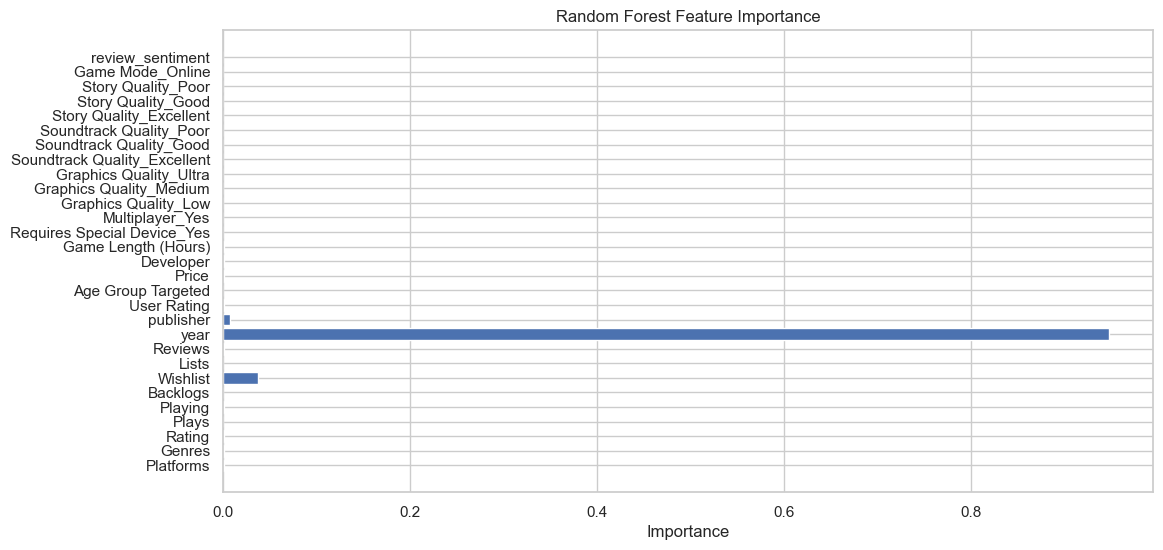

In [25]:
importances_rf = rf_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(12,6))
plt.barh(feat_names, importances_rf)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importance")
plt.show()


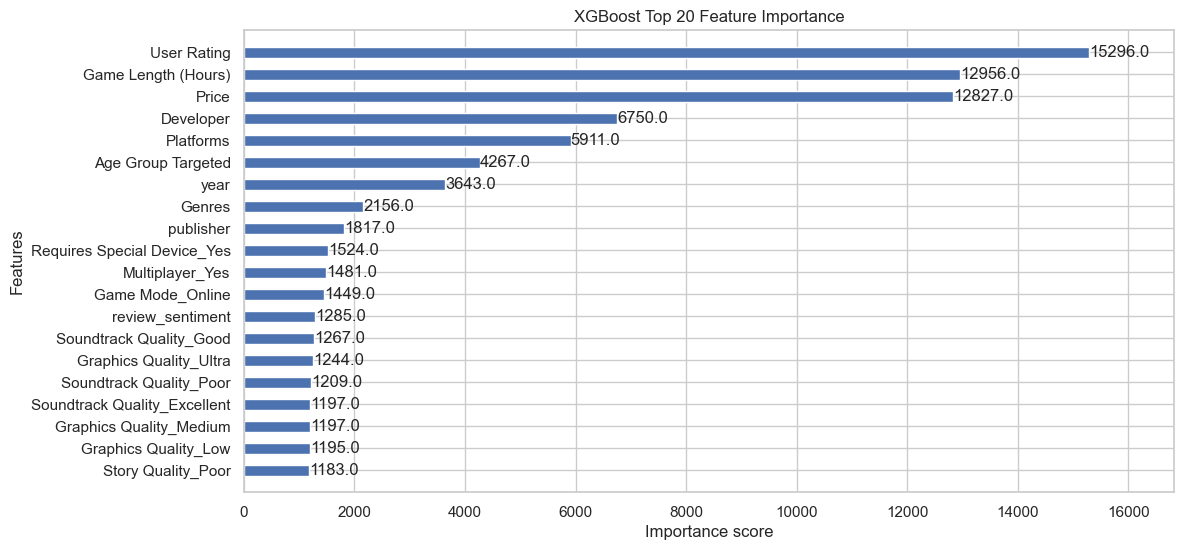

In [26]:
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='weight', height=0.5)
plt.title("XGBoost Top 20 Feature Importance")
plt.show()
